# california_housing_ml_pipeline
#### Charging Necessary Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


#### Load dataset

In [3]:
print("Loading California housing dataset...")
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name='MedHouseVal')
df = pd.concat([X, y], axis=1)

Loading California housing dataset...


## Exploratory Analysis EDA


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Missing Values:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Summary Statistics:
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
m

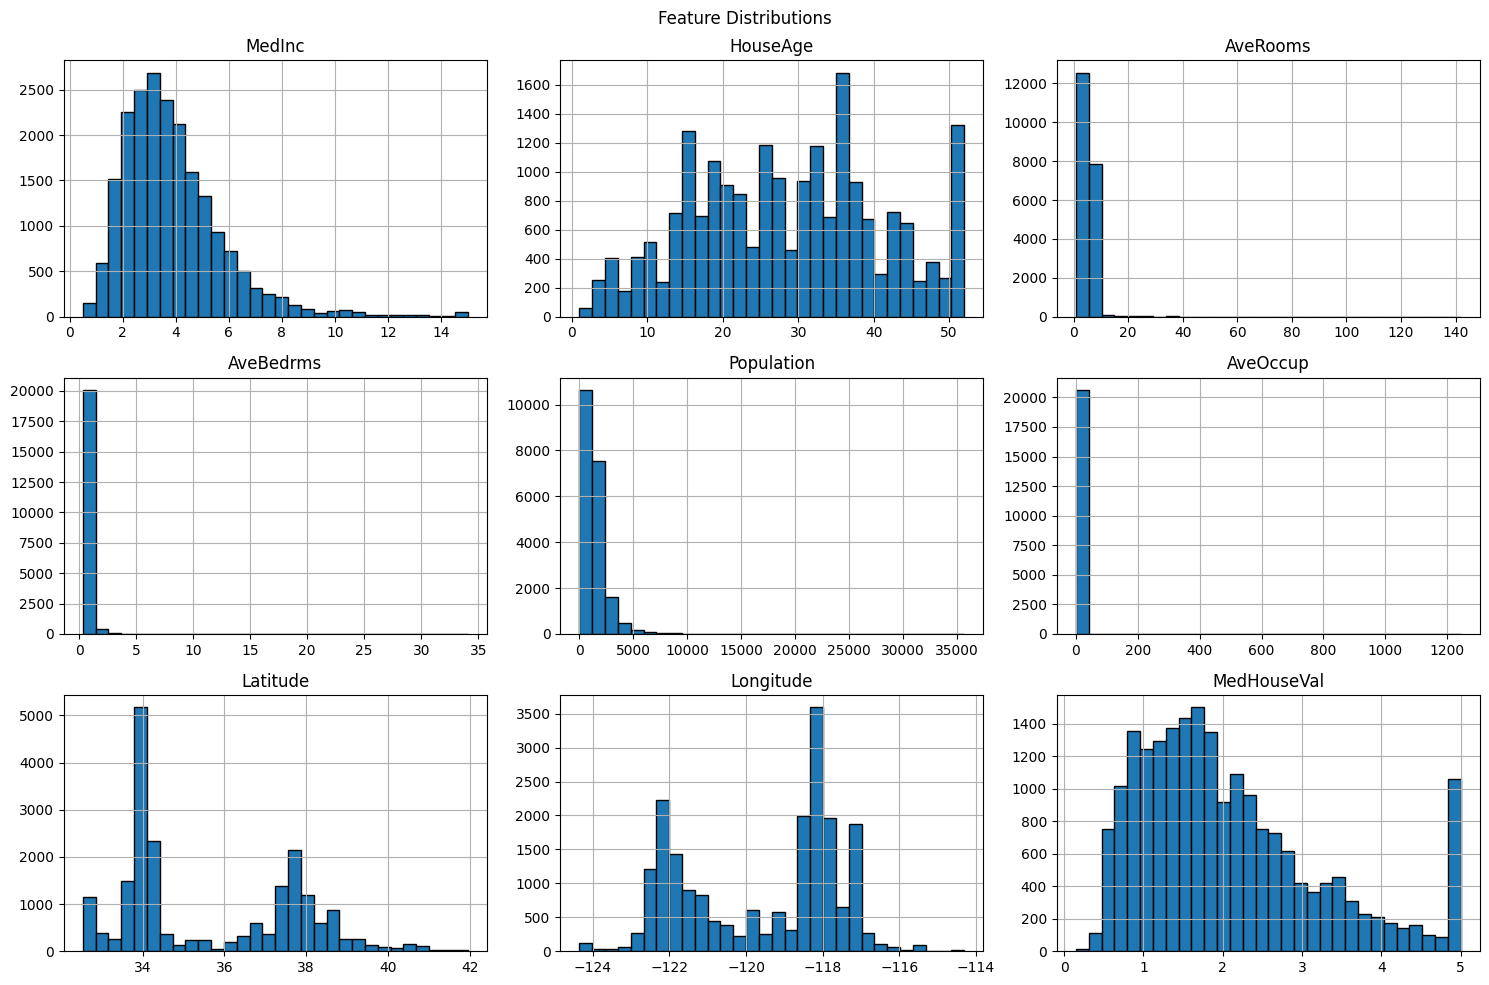

In [4]:

# Initial Inspection
print("\nInitial Data Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())
# Histograms for all features
print("Plotting histograms...")
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()


## Data Preparation 

In [5]:

# Train-Test Split
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal']
print("Splitting data into train and test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Splitting data into train and test...


Plotting boxplots for outlier detection...


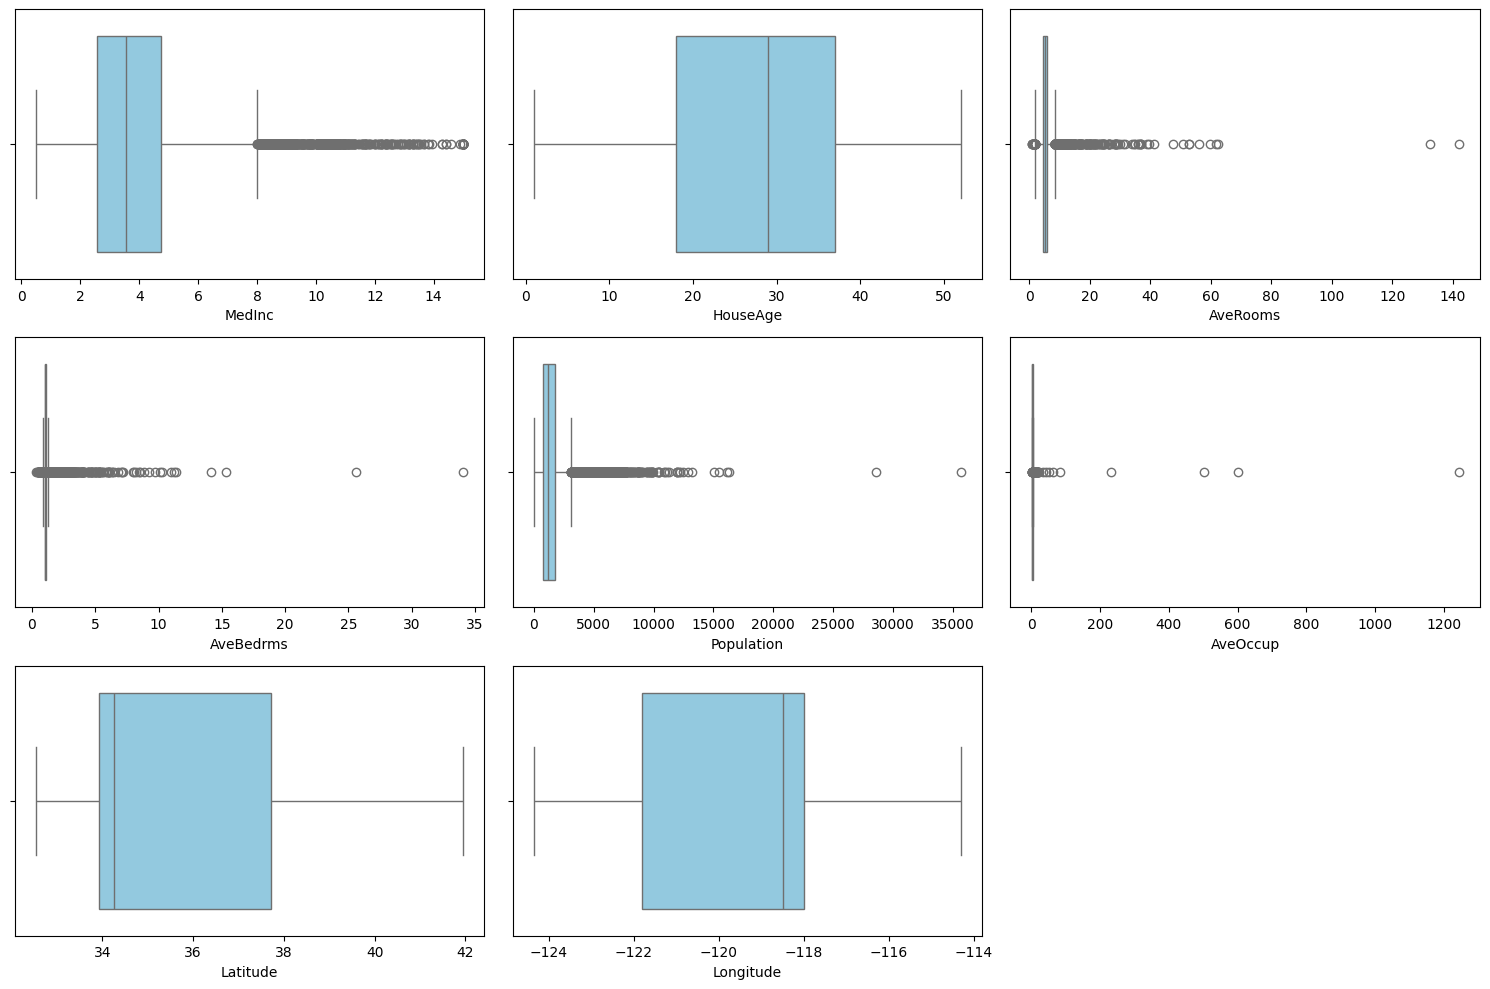

In [6]:

# Boxplots to detect outliers
print("Plotting boxplots for outlier detection...")
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[column], color='skyblue')
plt.tight_layout()
plt.show()


Plotting correlation matrix...


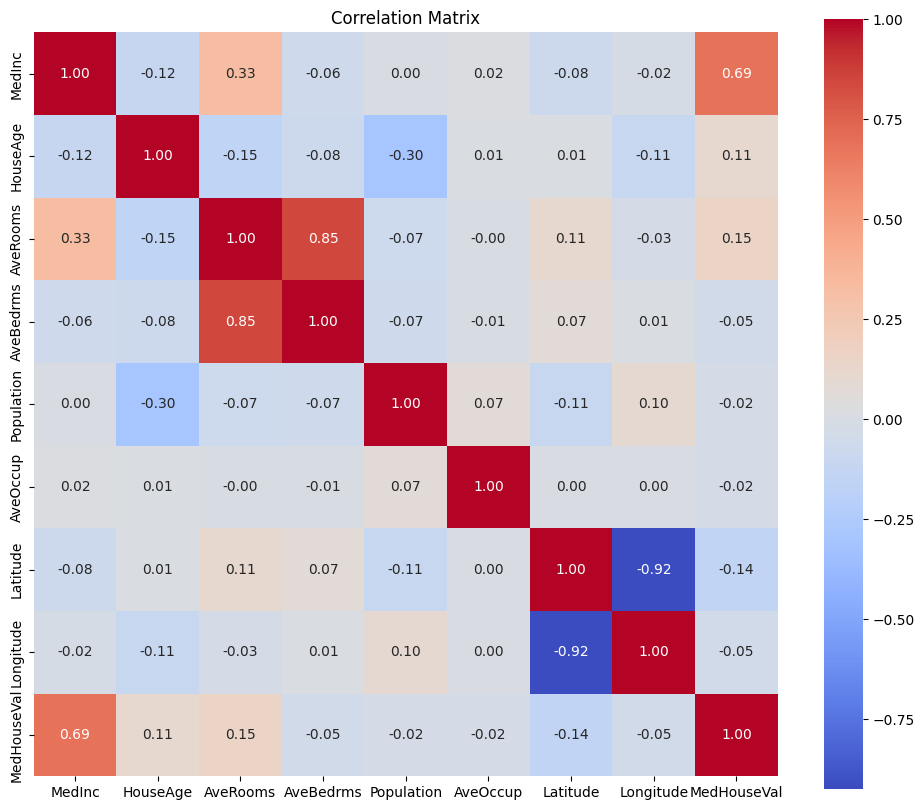

In [7]:

# Correlation Heatmap
print("Plotting correlation matrix...")
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()


Plotting scatterplots: Target vs Features...


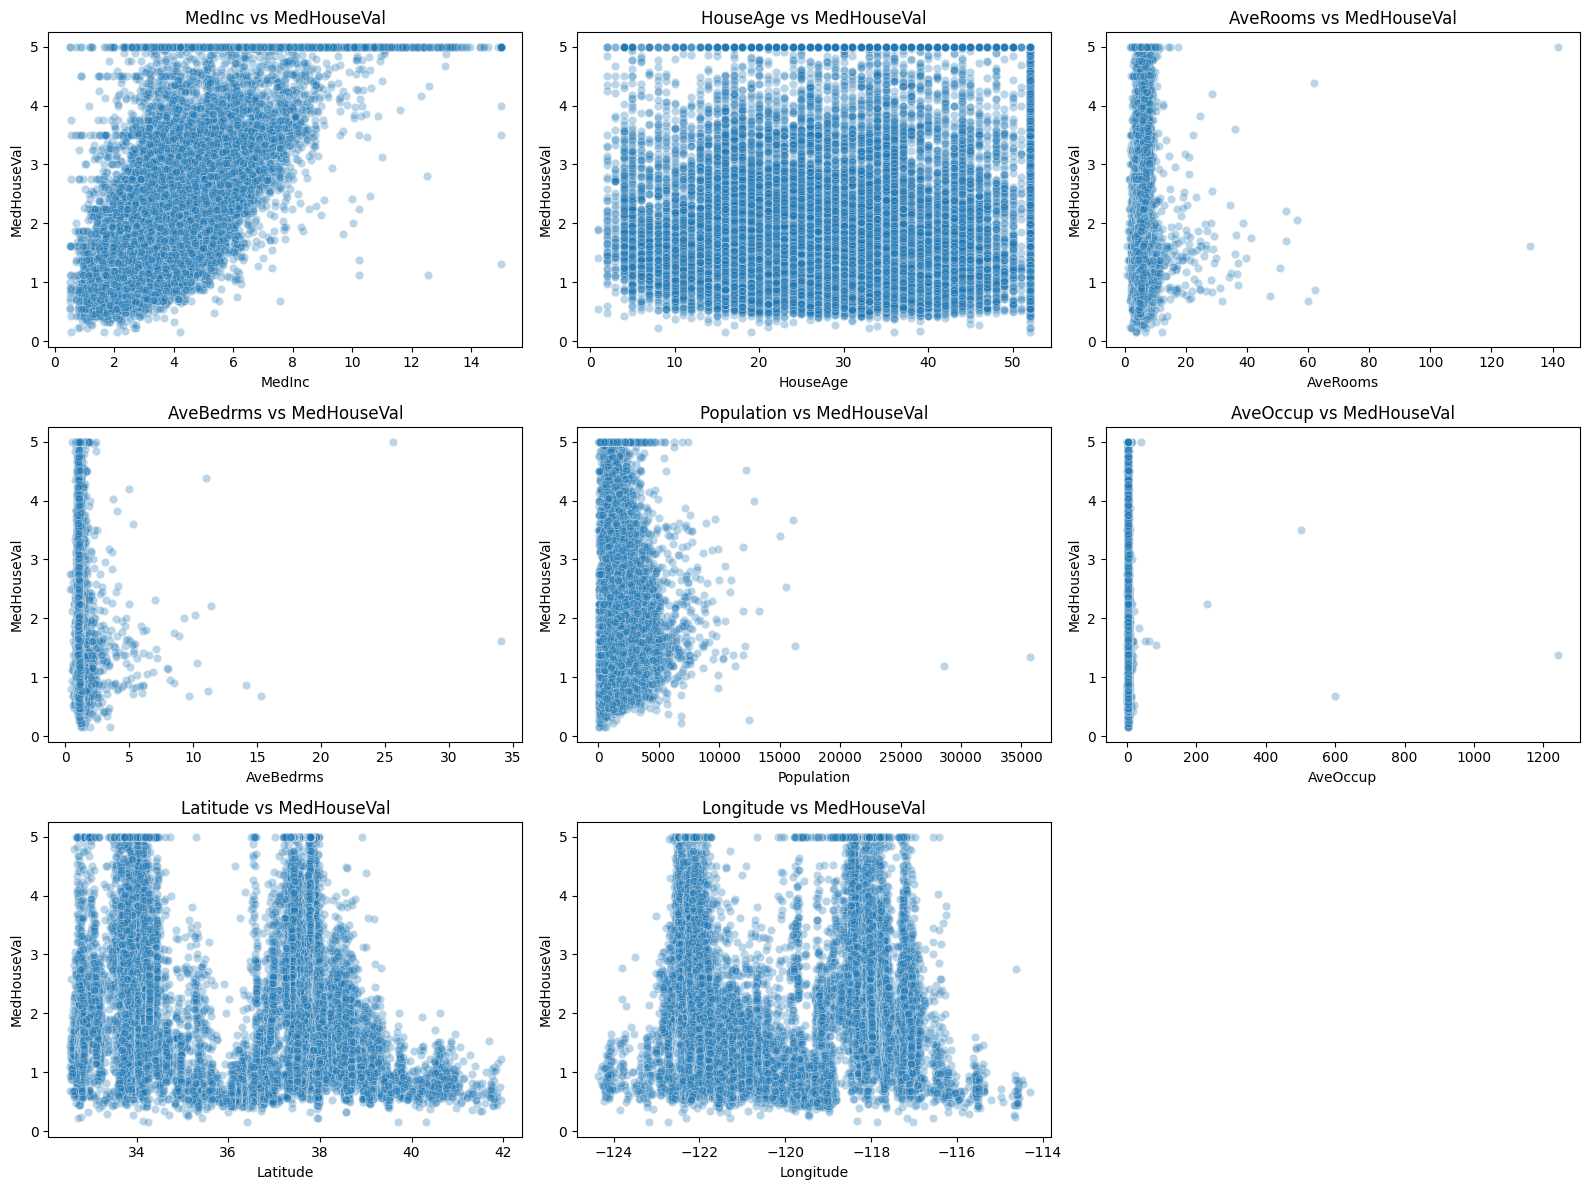

In [8]:

# Target vs Feature scatterplots
print("Plotting scatterplots: Target vs Features...")
plt.figure(figsize=(16, 12))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=df[column], y=df['MedHouseVal'], alpha=0.3)
    plt.title(f"{column} vs MedHouseVal")
plt.tight_layout()
plt.show()


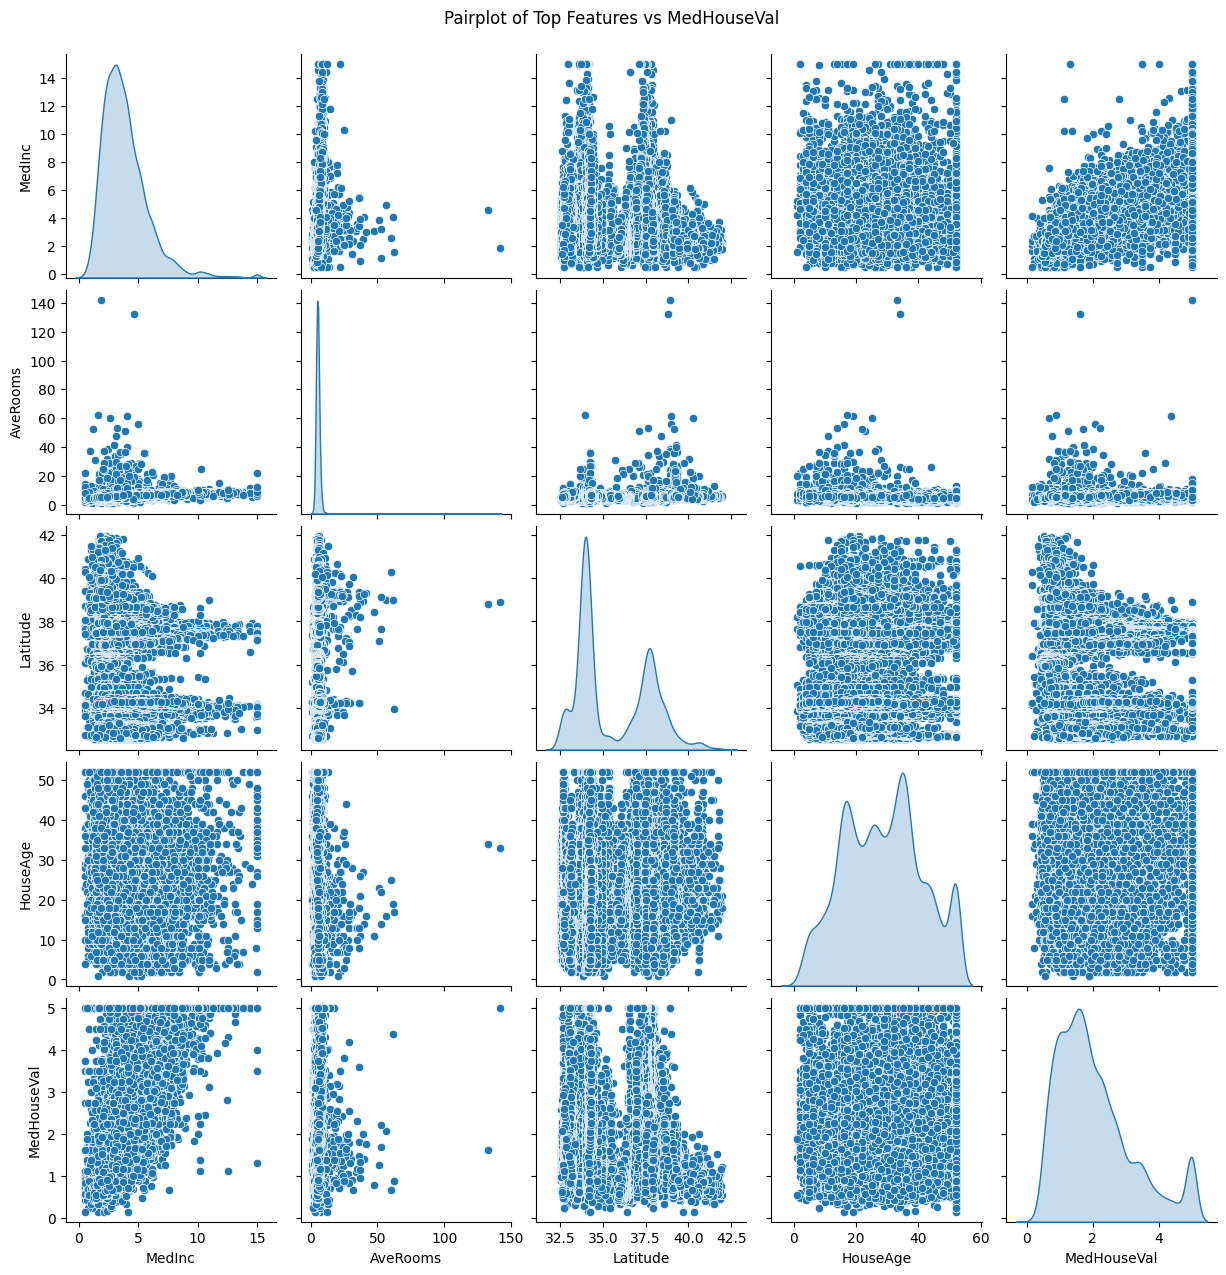

In [9]:

# Pairplot (only top correlated features to target)
top_corr_features = corr_matrix['MedHouseVal'].abs().sort_values(ascending=False)[1:5].index.tolist()
sns.pairplot(df[top_corr_features + ['MedHouseVal']], diag_kind='kde')
plt.suptitle("Pairplot of Top Features vs MedHouseVal", y=1.02)
plt.show()


## Training

In [10]:

# Train Linear Regression
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Train Random Forest
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


Training Linear Regression model...
Training Random Forest Regressor...


RandomForestRegressor(random_state=42)

### Model Evaluation

In [11]:

# Evaluation Function
def evaluate_model(model, X, y, name="Model"):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"\n{name} Performance:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    return mse, r2

# Evaluate Models
evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")


Linear Regression Performance:
Mean Squared Error: 0.5559
R² Score: 0.5758

Random Forest Performance:
Mean Squared Error: 0.2554
R² Score: 0.8051


(0.2553684927247781, 0.8051230593157366)

### Feature Importance Plot

In [12]:
# 15. Feature Importance Plot
print("Plotting feature importances from Random Forest...")
importances = rf_model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


Plotting feature importances from Random Forest...


C:\Users\mohd1\AppData\Local\Temp\ipykernel_31460\1656486575.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")


In [13]:
# 16. Overfitting Test
print("Checking for overfitting...")

def plot_overfitting_check(model, X_train, X_test, y_train, y_test, model_name):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    plt.figure(figsize=(6, 4))
    sns.barplot(x=[f'{model_name} Train', f'{model_name} Test'], 
                y=[train_rmse, test_rmse], palette='coolwarm')
    plt.ylabel('RMSE')
    plt.title(f'Overfitting Check: {model_name}')
    plt.ylim(0, max(train_rmse, test_rmse) * 1.2)
    plt.tight_layout()
    plt.show()

# Apply to both models
plot_overfitting_check(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
plot_overfitting_check(rf_model, X_train, X_test, y_train, y_test, "Random Forest")


Checking for overfitting...


C:\Users\mohd1\AppData\Local\Temp\ipykernel_31460\1146878413.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'{model_name} Train', f'{model_name} Test'],


C:\Users\mohd1\AppData\Local\Temp\ipykernel_31460\1146878413.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'{model_name} Train', f'{model_name} Test'],


### Saving Models for further use 

In [14]:
print("Saving models and scaler...")
joblib.dump(lr_model, "linear_regression_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Full pipeline completed with EDA and model training.")

Saving models and scaler...
✅ Full pipeline completed with EDA and model training.
